##  旋转

In [2]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
import os

In [4]:
def parse_tuple(value):
    try:
        # 尝试将字符串解析为数值元组
        return np.array(ast.literal_eval(value)) if isinstance(value, str) else np.array(value)
    except (ValueError, SyntaxError):
        print(f"Error parsing value: {value}")
        return np.array([np.nan, np.nan])
def list_csv_files(directory_path):
    csv_files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]
    csv_files.sort()  # This sorts the files in ascending order by filename
    return csv_files

In [6]:
def translate_and_rotate(df):
        # List of required columns
    required_columns = ['center-euclidian','head','generation_best_fitness_score']
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        print(f"Missing columns: {', '.join(missing_columns)}. Skipping file.")
        return None  # Skip if any required columns are missing
        
    # Parse 'center-euclidian' and 'head' as tuples
    center_str = parse_tuple(df['center-euclidian'].iloc[0])
    head_str = parse_tuple(df['head'].iloc[0])
    # 检查中心点和头部点是否有效
    if not isinstance(center_str, (tuple, list, np.ndarray)) or not isinstance(head_str, (tuple, list, np.ndarray)):
        print(f"Invalid format for center or head in first frame: center={center_str}, head={head_str}")
        return None
    # Convert head and center points to np.array if they are not
    center_str = np.array(center_str)
    head_str = np.array(head_str)
    # 计算 forward 列
    df['forward'] = df['head'].apply(lambda h: parse_tuple(h) - center_str if isinstance(h, str) else np.array([np.nan, np.nan]))
    forward_str = df['forward'].iloc[0]
    
    try:
        head_x, head_y = head_str
        center_x, center_y = center_str
        forward_x, forward_y = forward_str
    except ValueError:
        print(f"Error parsing center or forward in the first frame: {center_str}, {forward_str}")
        return None
        
    theta = (np.pi / 2)-np.arctan2(forward_y, forward_x)

    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

    transformed_data = []
    
    for index, row in df.iterrows():
        transformed_points = {}

        transformed_points['generation_best_fitness_score'] = row.get('generation_best_fitness_score', np.nan)
        transformed_points['generation_id'] = row.get('generation_id', np.nan)
        transformed_points['frame_id'] = row.get('frame_id', np.nan)
        points_to_transform = {
            'head': parse_tuple(row['head']),
            'center-euclidian': parse_tuple(row['center-euclidian']),
            'forward': parse_tuple(row['forward']),
            'middle': parse_tuple(row['middle']),
            'rear': parse_tuple(row['rear']),
            'right_front': parse_tuple(row['right_front']),
            'left_front': parse_tuple(row['left_front']),
            'right_hind': parse_tuple(row['right_hind']),
            'left_hind': parse_tuple(row['left_hind']),
        }
        for point_name, point_value in points_to_transform.items():
            try:
                if np.isnan(point_value).any():
                    print(f"Skipping {point_name} due to missing value.")
                    continue
                
                translated_point = point_value - head_str
                rotated_point = rotation_matrix @ translated_point
                transformed_points[point_name] = f"({rotated_point[0]:.2f}, {rotated_point[1]:.2f})"
            
            except Exception as e:
                print(f"Error parsing {point_name} with value {point_value}: {e}")
        
        transformed_data.append(transformed_points)

    return pd.DataFrame(transformed_data)


## 对文件夹下所有对csv进行旋转

In [8]:
input_directory = '/Users/jowonkim/Desktop/CPG/csv/last_gen'
output_directory = '/Users/jowonkim/Desktop/CPG/csv/last_gen/processed'

# Create output directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# List all CSV files in the directory
csv_files = list_csv_files(input_directory)

# Iterate over each CSV file in the directory
for csv_file in csv_files:
    file_path = os.path.join(input_directory, csv_file)  # Full path to the CSV file
    df = pd.read_csv(file_path, skipfooter=1, engine='python')
    
    # Apply the transformation function
    transformed_df = translate_and_rotate(df)
    
    # Save the transformed CSV if it's valid
    if transformed_df is not None:
        output_file_path = os.path.join(output_directory, csv_file.replace('.csv', '_00.csv'))
        transformed_df.to_csv(output_file_path, index=False)
        print(f"Processed and saved: {output_file_path}")

Processed and saved: /Users/jowonkim/Desktop/CPG/csv/last_gen/processed/last_generation_00.csv


## 相似度计算

In [10]:
# import pandas as pd

# # 读取原始 CSV 文件
# file_path = ''

import os

# 读取原始 CSV 文件
file_path = '/Users/jowonkim/Desktop/CPG/csv/last_gen/processed/last_generation_00.csv'
df = pd.read_csv(file_path)

# 根据 generation_id 分组
groups = df.groupby('generation_id')

# 设置输出路径
output_directory ='/Users/jowonkim/Desktop/CPG/csv/last_gen/processed/run_9'

# 确保输出目录存在
os.makedirs(output_directory, exist_ok=True)

# 将每个组写入单独的 CSV 文件
for generation_id, group in groups:
    output_file_path = os.path.join(output_directory, f'generation_{generation_id}.csv')  # 创建完整的输出路径
    group.to_csv(output_file_path, index=False)  # 不包含索引列
    print(f'Generated: {output_file_path}')

Generated: /Users/jowonkim/Desktop/CPG/csv/last_gen/processed/run_9/generation_299.csv


In [12]:
# 解析函数，将字符串形式的坐标解析为(x, y)
def parse_tuple_string(s):
    return ast.literal_eval(s) if pd.notna(s) else (None, None)

# 提取关键点向量
def extract_keypoints(data_dict):
    keypoints = []
    
    if isinstance(data_dict, dict):
        for name, coord in data_dict.items():
            if coord != (None, None): 
                keypoints.append(coord)
    elif isinstance(data_dict, pd.DataFrame) or isinstance(data_dict, pd.Series):
        keypoints = data_dict[['X (relative)', 'Y (relative)']].values.flatten()
    
    return np.array(keypoints).flatten()  # 将二维坐标转为一维向量

# 计算两个姿态向量的余弦相似性
def calculate_cosine_similarity(vec1, vec2):
    vec1 = vec1.reshape(1, -1)  # 确保向量是二维的
    vec2 = vec2.reshape(1, -1)
    return cosine_similarity(vec1, vec2)[0][0]  # 返回相似性

def calculate_mse(vec1, vec2):
    # 确保两个向量具有相同的长度
    if vec1.shape != vec2.shape:
        raise ValueError("Input vectors must have the same shape")
    
    return np.mean((vec1 - vec2) ** 2)  # 计算均方误差

In [14]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# 设置输入和输出路径
input_directory = '/Users/jowonkim/Desktop/CPG/csv/last_gen/processed/run_9'  # 输入文件夹
output_directory = '/Users/jowonkim/Desktop/CPG/csv/last_gen/processed/run_9/scaled/'  # 输出文件夹

# 确保输出目录存在
os.makedirs(output_directory, exist_ok=True)

# 自定义的缩放函数
def scale_robot_coordinates(df_1, df_2):
    first_frames_1 = df_1[df_1['Color'] != 'tail']
    
    # 获取 'neck' 点的坐标
    neck_points = first_frames_1[first_frames_1['Color'] == 'neck'][['Frame', 'X (relative)', 'Y (relative)']]
    

    coordinates_2_list = []
    for index, frame in df_2.iterrows():
        coordinates_2 = {
            'head': parse_tuple_string(frame.get('head', None)),  
            'middle': parse_tuple_string(frame.get('middle', None)),  
            'rear': parse_tuple_string(frame.get('rear', None)),  
            'right_front': parse_tuple_string(frame.get('right_front', None)),
            'left_front': parse_tuple_string(frame.get('left_front', None)),  
            'right_hind': parse_tuple_string(frame.get('right_hind', None)),  
            'left_hind': parse_tuple_string(frame.get('left_hind', None)), 
        }
            # 调试输出
        if None in coordinates_2.values() or any(v is None for v in coordinates_2.values()):
            print(f'Frame {index}: Incomplete robot coordinates: {coordinates_2}')
            
        coordinates_2_list.append(coordinates_2)
    # 计算全局最大距离
    global_max_distance_animal = 0
    global_max_distance_robot = 0
    # global_max_distance_animal =168.13387523042465
    # global_max_distance_robot =0.367967389859482

    keypoints_of_interest = ['neck', 'body1', 'body2', 'ru_hand', 'lu_hand', 'rd_hand', 'ld_hand']
    for i in range(884):
        animal_neck = first_frames_1[(first_frames_1['Frame'] == i) & (first_frames_1['Color'] == 'neck')]
        
        if animal_neck.empty:
            print(f'Frame {i + 1}: Neck coordinates not found, skipping this frame.')
            continue
        animal_neck = animal_neck[['X (relative)', 'Y (relative)']].values[0]  # 取首个元素
        
        animal_coordinates = first_frames_1.loc[
            (first_frames_1['Frame'] == i) & (first_frames_1['Color'].isin(keypoints_of_interest)),
            ['X (relative)', 'Y (relative)']
        ].values.flatten()
        
        robot_coordinates = extract_keypoints(coordinates_2_list[i])  # 提取机器人关键点
        
        if animal_coordinates.size != robot_coordinates.size:
            print(f'Frame {i + 1}: One of the keypoints is missing, skipping this frame.')
            print('animal_coordinates.size', animal_coordinates.size)
            print('robot_coordinates.size:',robot_coordinates.size)
            continue  # 跳过关键点数量不匹配的帧
        
        # 计算动物每个关键点到颈部的距离
        distances = np.linalg.norm(animal_coordinates.reshape(-1, 2) - animal_neck.reshape(1, 2), axis=1)
        max_distance_animal = np.max(distances)

        # 更新全局最大动物距离
        if max_distance_animal > global_max_distance_animal:
            global_max_distance_animal = max_distance_animal

        robot_head = coordinates_2_list[i]['head']
        robot_boxes = np.array([coordinates_2_list[i][box_name] for box_name in ['middle', 'rear', 'right_front', 'left_front', 'right_hind', 'left_hind']])
        robot_distances = np.linalg.norm(robot_boxes - robot_head, axis=1)
        max_distance_robot = np.max(robot_distances)

        # 更新全局最大机器人距离
        if max_distance_robot > global_max_distance_robot:
            global_max_distance_robot = max_distance_robot

    # 打印全局最大距离
    print(f'Global maximum distance (animal): {global_max_distance_animal}')
    print(f'Global maximum distance (robot): {global_max_distance_robot}')

    scaled_robot_data = []
    scaling_factor = global_max_distance_animal / global_max_distance_robot
    
    # 以第一帧的head位置作为初始基准点
    first_robot_head = np.array(coordinates_2_list[0]['head']).reshape(1, 2)
    
    for i in range(884):
        # 获取动物和机器人对应帧的关键点
        animal_neck = first_frames_1[(first_frames_1['Frame'] == i) & (first_frames_1['Color'] == 'neck')]
        if animal_neck.empty:
            continue
        animal_coordinates = first_frames_1.loc[
            (first_frames_1['Frame'] == i) & (first_frames_1['Color'].isin(keypoints_of_interest)),
            ['X (relative)', 'Y (relative)']
        ].values.flatten()
    
        robot_coordinates = extract_keypoints(coordinates_2_list[i])
        robot_head = np.array(coordinates_2_list[i]['head']).reshape(1, 2)
    
        if animal_coordinates.size != robot_coordinates.size:
            continue
    
        # 以第一帧的head位置作为基准进行缩放
        robot_coordinates = robot_coordinates.reshape(-1, 2)
        scaled_robot_coordinates = (robot_coordinates - first_robot_head) * scaling_factor + first_robot_head
    
        scaled_robot_data.append({
            'Frame': i,
            'head': tuple(scaled_robot_coordinates[0]),       # head 缩放后的位置
            'middle': tuple(scaled_robot_coordinates[1]),
            'rear': tuple(scaled_robot_coordinates[2]),
            'right_front': tuple(scaled_robot_coordinates[3]),
            'left_front': tuple(scaled_robot_coordinates[4]),
            'right_hind': tuple(scaled_robot_coordinates[5]),
            'left_hind': tuple(scaled_robot_coordinates[6]),
        })
    
    return pd.DataFrame(scaled_robot_data)

# 遍历输入目录中的所有 CSV 文件
for filename in os.listdir(input_directory):
    if filename.endswith('.csv'):
        file_path_2 = os.path.join(input_directory, filename)
        df_2 = pd.read_csv(file_path_2, on_bad_lines='skip')

        # 读取第二个 CSV 文件，这里假设是您要处理的机器人数据文件
        # 根据需要替换路径
        file_path_1 = '/Users/jowonkim/Desktop/CPG/extended_152_with_y_increment.csv'
        df_1 = pd.read_csv(file_path_1, on_bad_lines='skip')

        # 执行缩放
        scaled_robot_df = scale_robot_coordinates(df_1, df_2)

        # 保存缩放后的 DataFrame
        output_file_path = os.path.join(output_directory, f'scaled_{filename}')
        scaled_robot_df.to_csv(output_file_path, index=False)

        print(f'Scaled coordinates saved to {output_file_path}')

Global maximum distance (animal): 168.13387523042465
Global maximum distance (robot): 0.367967389859482
Scaled coordinates saved to /Users/jowonkim/Desktop/CPG/csv/last_gen/processed/run_9/scaled/scaled_generation_299.csv


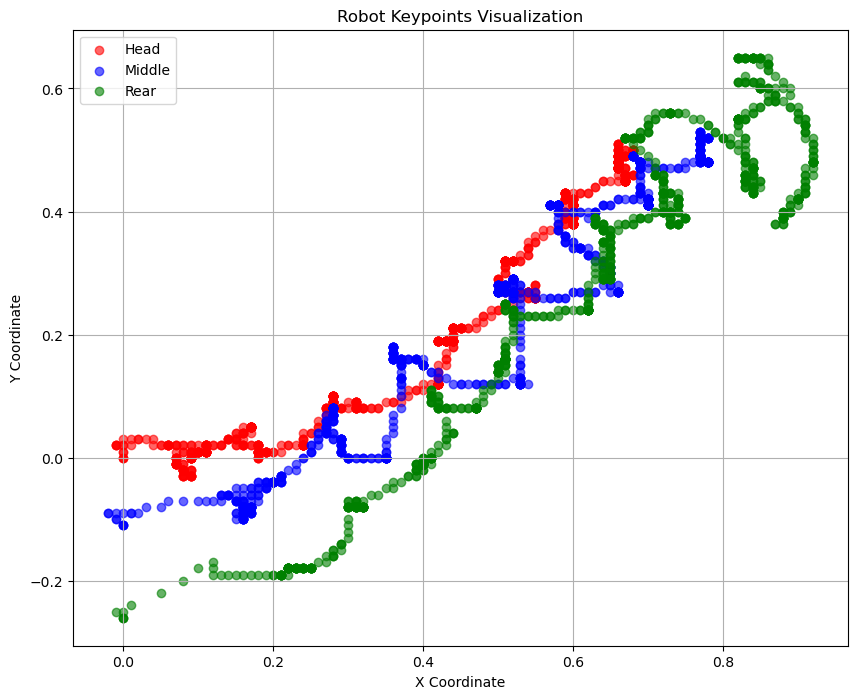

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# 设置输入文件路径
input_file_path = '/Users/jowonkim/Desktop/CPG/csv/last_gen/processed/run_9/generation_299.csv'

# 读取 CSV 文件
df = pd.read_csv(input_file_path)

# 提取需要可视化的坐标
# 假设我们要可视化的是头部和其他关节
head_coords = df['head'].apply(eval).tolist()  # 将字符串元组转换为元组
middle_coords = df['middle'].apply(eval).tolist()
rear_coords = df['rear'].apply(eval).tolist()

# 将坐标拆分为 x 和 y 列表
head_x, head_y = zip(*head_coords)
middle_x, middle_y = zip(*middle_coords)
rear_x, rear_y = zip(*rear_coords)

# 创建一个散点图
plt.figure(figsize=(10, 8))
plt.scatter(head_x, head_y, color='red', label='Head', alpha=0.6)
plt.scatter(middle_x, middle_y, color='blue', label='Middle', alpha=0.6)
plt.scatter(rear_x, rear_y, color='green', label='Rear', alpha=0.6)

# 添加标题和标签
plt.title('Robot Keypoints Visualization')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid()

# 显示图形
plt.show()

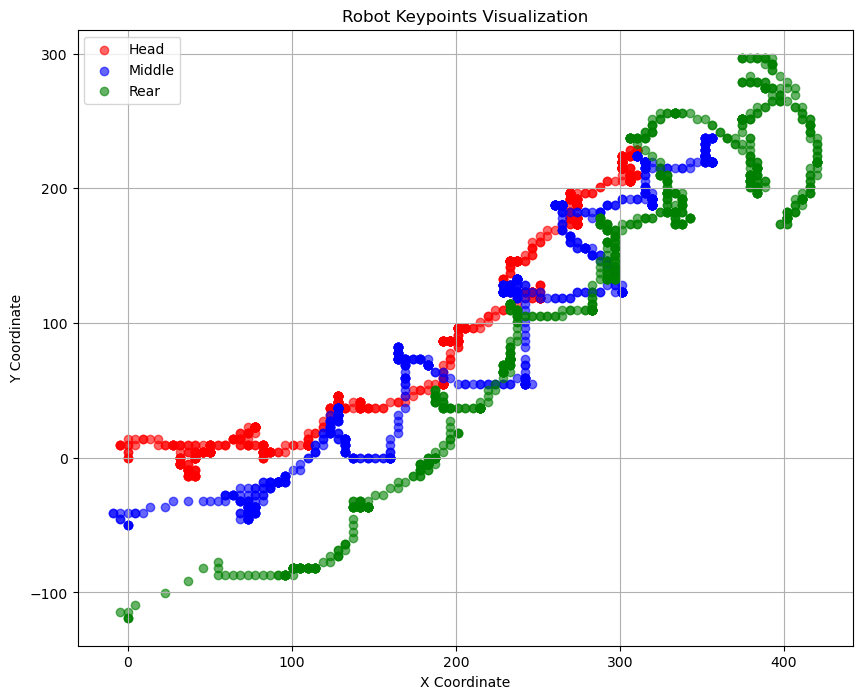

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# 设置输入文件路径
input_file_path = '/Users/jowonkim/Desktop/CPG/csv/last_gen/processed/run_9//scaled/scaled_generation_299.csv'

# 读取 CSV 文件
df = pd.read_csv(input_file_path)

# 提取需要可视化的坐标
# 假设我们要可视化的是头部和其他关节
head_coords = df['head'].apply(eval).tolist()  # 将字符串元组转换为元组
middle_coords = df['middle'].apply(eval).tolist()
rear_coords = df['rear'].apply(eval).tolist()

# 将坐标拆分为 x 和 y 列表
head_x, head_y = zip(*head_coords)
middle_x, middle_y = zip(*middle_coords)
rear_x, rear_y = zip(*rear_coords)

# 创建一个散点图
plt.figure(figsize=(10, 8))
plt.scatter(head_x, head_y, color='red', label='Head', alpha=0.6)
plt.scatter(middle_x, middle_y, color='blue', label='Middle', alpha=0.6)
plt.scatter(rear_x, rear_y, color='green', label='Rear', alpha=0.6)

# 添加标题和标签
plt.title('Robot Keypoints Visualization')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid()

# 显示图形
plt.show()